In [ ]:
"""
Author: Eunmi Joo

Model Selection base on Validation & Test Accuracy

1. Select 10 highest validation accuracy models
2. Select 2 highest test accuarcy models as best models
"""

In [1]:
import torch
import os
device = "cuda:6" if torch.cuda.is_available() else "cpu"
torch.cuda.set_device(device)
import seaborn as sns
import pickle
import numpy as np
from tqdm.notebook import tqdm
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
# from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

warnings.filterwarnings("ignore")

In [2]:
with open("/ceph/inestp02/stroke_classifier/data/patientwise/preprocess/features_resnet152.pickle", "rb") as f:
    features = pickle.load(f)
with open('/ceph/inestp02/stroke_classifier/data/patientwise/preprocess/patient_data_combine_wo_dicom.pickle', 'rb') as f:
    patientwise_scans = pickle.load(f)

In [3]:
#BiGRU/ should data be padded front and back since it's bidirectional?? 
#atm, padding is only at the back

class PatientwiseDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        return x, y

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 80):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


class CNNTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation="relu"):
        super(CNNTransformer, self).__init__()
        
        # fine_cnn = cnn_model
        # modules = list(fine_cnn.children())[:-1]
        # self.cnn = nn.Sequential(*modules)
        
        # self.embedding = nn.Linear(in_features, d_model)
        
        self.encoder_layer = nn.TransformerEncoderLayer(input_dim, nhead, dim_feedforward, dropout, activation)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        self.fc = nn.Linear(d_model, output_dim)

    def forward(self, x):
        x = x.permute(1, 0, 2)
        x = self.encoder(x)
        # print(x.shape)
        x.shape
        
        x = x.mean(dim=0)  # Average pooling across the sequence length dimension
        # print(x.shape)
        x = self.fc(x)
        # print(x.shape)
        return x
    
# Set the hyperparameters

model = models.resnet152(weights="DEFAULT")
# in_features = model.fc.in_features

In [4]:
state_dict_path = f'models_state_dict/runs/'
if not os.path.exists(state_dict_path):
        os.makedirs(state_dict_path)

#model save path
model_path = f'models/runs/'
if not os.path.exists(model_path):
        os.makedirs(model_path)

#tensorboard path
tensorboard_path = f'tensorboard/runs/'
if not os.path.exists(tensorboard_path):
        os.makedirs(tensorboard_path)

In [5]:
X = features
y = torch.Tensor(list(i['patient_label'] for i in patientwise_scans.values()))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
train_dataset = PatientwiseDataset(X_train, y_train)
test_dataset = PatientwiseDataset(X_test, y_test)
val_dataset = PatientwiseDataset(X_val, y_val)

In [18]:
def test_accuracy(model, print_result = False):
    #test
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle = False)

    # Initialize variables to track loss and accuracy
    test_acc = 0.0
    predicted_labels = []
    true_labels = []

    # Disable gradient computation
    with torch.no_grad():
        # Iterate over validation data
        for batch_inputs, batch_targets in test_loader:
            batch_inputs = batch_inputs.squeeze().to(device)
            one_hot_targets = F.one_hot(batch_targets.long(), num_classes=3)
            one_hot_targets = one_hot_targets.to(device)
            
            outputs = model(batch_inputs)
            
            predicted = torch.argmax(outputs, 1)
            test_acc += (predicted == batch_targets.to(device)).sum().item()
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(batch_targets.cpu().numpy())

    test_acc /= len(test_loader.dataset)
    
    if print_result:
        print("f1 score:", f1_score(true_labels, predicted_labels, average=None))
        sns.heatmap(confusion_matrix(true_labels, predicted_labels), annot=True)
    
    return test_acc

In [7]:
with open("/ceph/inestp02/stroke_classifier/src/transformer/loss_lst.pickle", 'rb') as f:
    loss_lst = pickle.load(f)

In [8]:
loss_np = np.array(loss_lst)
sorted_idx = np.argsort(loss_np)[:10]
sorted_idx

array([230, 215, 122, 203,  57,  11,  81, 214,  33,  69])

In [19]:
for idx in sorted_idx:
    checkpoint = torch.load(f"./transformer/transformer_classifier_{idx}.pth")

    input_dim = checkpoint['input_dim']
    output_dim = checkpoint['output_dim']
    d_model = checkpoint['d_model']
    nhead = checkpoint['nhead']
    dim_feedforward = checkpoint['dim_feedforward']
    dropout = checkpoint['dropout']

    model = CNNTransformer(input_dim, output_dim, d_model, nhead, dim_feedforward, dropout, activation="relu").to(device)

    model.load_state_dict(checkpoint['model_state_dict'])

    print(f"test acc of {idx}th model:", test_accuracy(model))

test acc of 230th model: 0.7353760445682451
test acc of 215th model: 0.7910863509749304
test acc of 122th model: 0.7576601671309192
test acc of 203th model: 0.7325905292479109
test acc of 57th model: 0.7075208913649025
test acc of 11th model: 0.6239554317548747
test acc of 81th model: 0.83008356545961
test acc of 214th model: 0.7883008356545961
test acc of 33th model: 0.8328690807799443
test acc of 69th model: 0.8022284122562674


f1 score: [0.75313808 0.75303644 0.99137931]
test acc of 69th model: 0.83008356545961


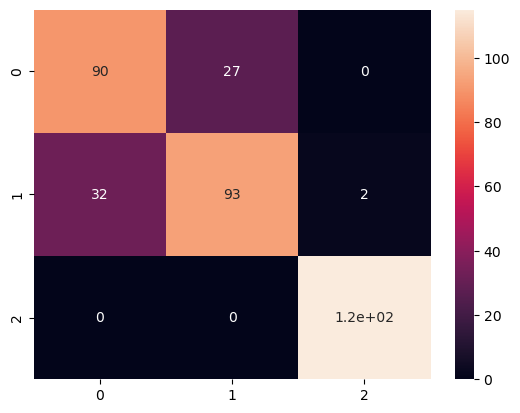

In [20]:
checkpoint = torch.load(f"./transformer/transformer_classifier_81.pth")

input_dim = checkpoint['input_dim']
output_dim = checkpoint['output_dim']
d_model = checkpoint['d_model']
nhead = checkpoint['nhead']
dim_feedforward = checkpoint['dim_feedforward']
dropout = checkpoint['dropout']

model = CNNTransformer(input_dim, output_dim, d_model, nhead, dim_feedforward, dropout, activation="relu").to(device)

model.load_state_dict(checkpoint['model_state_dict'])

print(f"test acc of {idx}th model:", test_accuracy(model, print_result=True))

f1 score: [0.75744681 0.76       0.98712446]
test acc of 69th model: 0.8328690807799443


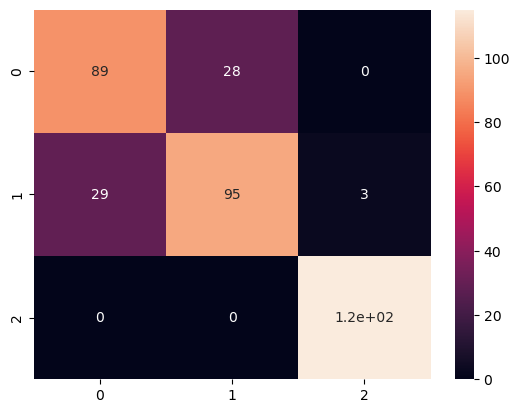

In [21]:
checkpoint = torch.load(f"./transformer/transformer_classifier_33.pth")

input_dim = checkpoint['input_dim']
output_dim = checkpoint['output_dim']
d_model = checkpoint['d_model']
nhead = checkpoint['nhead']
dim_feedforward = checkpoint['dim_feedforward']
dropout = checkpoint['dropout']

model = CNNTransformer(input_dim, output_dim, d_model, nhead, dim_feedforward, dropout, activation="relu").to(device)

model.load_state_dict(checkpoint['model_state_dict'])

print(f"test acc of {idx}th model:", test_accuracy(model, print_result=True))